In [35]:
import os
import cv2
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Loading the data

In [36]:
# Load the data
images = np.load("images.npy")
masks = np.load("masks.npy")

print(f"Shape of the image: " + str(images.shape))
print(f"Shape of the mask: " + str(masks.shape))

# Normalize the images and masks to be in the range [0, 1]
images = images.astype('float32') / 255.0
masks = masks.astype('float32') / 255.0

# Split the dataset into training, validation, and test sets (90:10:10)
images_temp, images_test, masks_temp, masks_test = train_test_split(images, masks, test_size=0.1, random_state=42)
images_train, images_val, masks_train, masks_val = train_test_split(images_temp, masks_temp, test_size=(1/9), random_state=42)  # 1/9 is roughly 11.11%

# Convert the training, validation, and test sets into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
val_dataset = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, masks_test))

# Define batch size
batch_size = 32

# Prepare the datasets
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Information about the dataset splits
print(f"Training set: {len(images_train)} images")
print(f"Validation set: {len(images_val)} images")
print(f"Testing set: {len(images_test)} images")


Shape of the image: (2610, 64, 64, 3)
Shape of the mask: (2610, 64, 64)
Training set: 2088 images
Validation set: 261 images
Testing set: 261 images


## Visualizing the data

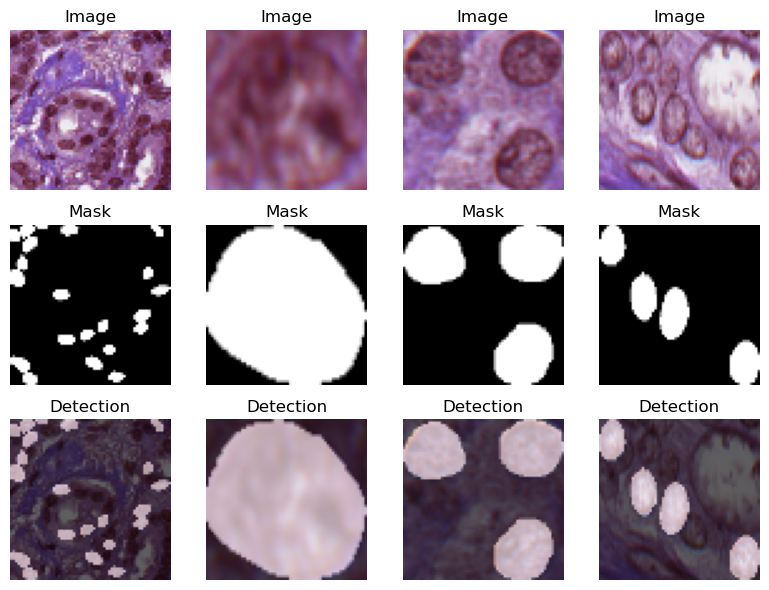

In [37]:
def plot_images_in_rows(images, masks, num_images=4):
    # Check if the number of images is more than what's available
    num_images = min(num_images, len(images))
    
    # Set up the figure size dynamically based on the number of images
    plt.figure(figsize=(8, 6))  # width for each column, height for 3 rows
    
    for i in range(num_images):
        # Original Images in first row
        plt.subplot(3, num_images, i + 1)  # 3 rows, num_images columns, current index + 1
        plt.imshow(images[i])
        plt.title('Image')
        plt.axis('off')

        # Masks in second row
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        # Overlay Mask on Original Image with Transparency in third row
        plt.subplot(3, num_images, num_images * 2 + i + 1)
        plt.imshow(images[i])
        plt.imshow(masks[i], cmap='gray', alpha=0.6)  # Overlay mask with transparency
        plt.title('Detection')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prepare the images and masks for plotting
images_to_plot = images_test[:4]  # Assuming images_test is a numpy array of shape (N, H, W, C)
masks_to_plot = masks_test[:4]  # Assuming masks_test is a numpy array of shape (N, H, W), with binary values

plot_images_in_rows(images_to_plot, masks_to_plot)

## Defining the model

In [38]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([decoder, concat_tensor], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = conv_block(decoder, num_filters)
    return decoder


def unet_model(input_size=(64, 64, 3), num_filters=64, num_classes=1):
    inputs = tf.keras.Input(shape=input_size)

    # Encoder (Downsampling)
    encoder0_pool, encoder0 = encoder_block(inputs, num_filters)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, num_filters * 2)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, num_filters * 4)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, num_filters * 8)
    
    # Bridge
    center = conv_block(encoder3_pool, num_filters * 16)

    # Decoder (Upsampling)
    decoder3 = decoder_block(center, encoder3, num_filters * 8)
    decoder2 = decoder_block(decoder3, encoder2, num_filters * 4)
    decoder1 = decoder_block(decoder2, encoder1, num_filters * 2)
    decoder0 = decoder_block(decoder1, encoder0, num_filters)
    
    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


# Create a basic U-Net model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to check the model
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 64, 64, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_44 (BatchN  (None, 64, 64, 64)  256         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_44[0]

 activation_53 (Activation)     (None, 4, 4, 1024)   0           ['batch_normalization_53[0][0]'] 
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 8, 8, 512)   2097664     ['activation_53[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_8 (Concatenate)    (None, 8, 8, 1024)   0           ['conv2d_transpose_8[0][0]',     
                                                                  'activation_51[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 8, 8, 1024)  4096        ['concatenate_8[0][0]']          
 ormalization)                                                                                    
          

 batch_normalization_63 (BatchN  (None, 64, 64, 128)  512        ['concatenate_11[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 activation_63 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_63[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 64, 64, 64)   73792       ['activation_63[0][0]']          
                                                                                                  
 batch_normalization_64 (BatchN  (None, 64, 64, 64)  256         ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

## Training the model 

Epoch 1/50
66/66 [==============================] - 295s 4s/step - loss: 0.3719 - accuracy: 0.7928 - val_loss: 3.8009 - val_accuracy: 0.4484
Epoch 2/50
66/66 [==============================] - 285s 4s/step - loss: 0.3111 - accuracy: 0.8259 - val_loss: 2.0764 - val_accuracy: 0.4559
Epoch 3/50
66/66 [==============================] - 276s 4s/step - loss: 0.2677 - accuracy: 0.8472 - val_loss: 1.8972 - val_accuracy: 0.6217
Epoch 4/50
66/66 [==============================] - 280s 4s/step - loss: 0.2331 - accuracy: 0.8642 - val_loss: 3.1736 - val_accuracy: 0.4729
Epoch 5/50
66/66 [==============================] - 281s 4s/step - loss: 0.2073 - accuracy: 0.8766 - val_loss: 0.8108 - val_accuracy: 0.6707
Epoch 6/50
66/66 [==============================] - 276s 4s/step - loss: 0.1905 - accuracy: 0.8837 - val_loss: 0.7893 - val_accuracy: 0.6760
Epoch 7/50
66/66 [==============================] - 297s 5s/step - loss: 0.1841 - accuracy: 0.8865 - val_loss: 0.4297 - val_accuracy: 0.8458
Epoch 8/50
66

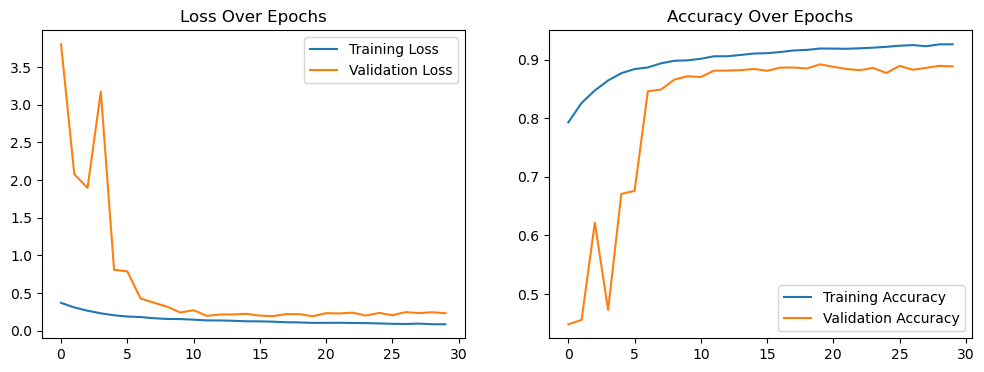

In [39]:
# Define callbacks (optional, but recommended)
# ModelCheckpoint to save the model after every epoch
model_checkpoint = ModelCheckpoint('unet_nuclei.h5', monitor='val_loss', save_best_only=True)
# EarlyStopping to stop training when the validation loss has not improved
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    verbose=1,
    validation_data=val_dataset,
    callbacks=[model_checkpoint, early_stopping]
)

# Plot training history (optional, but recommended for analysis)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## Predicting with the model

1/1 [==============================] - 0s 122ms/step


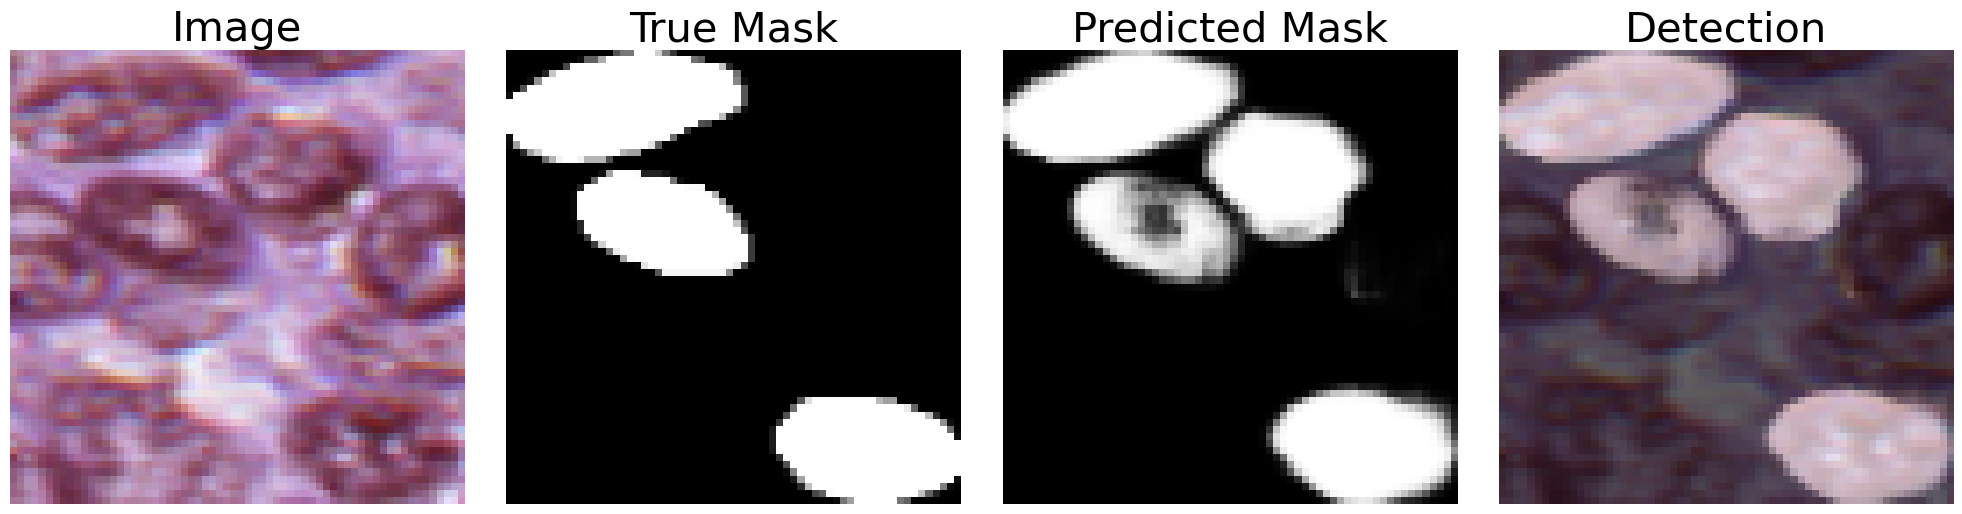

In [66]:
# Convert the test dataset back to numpy arrays for easy manipulation
test_images = np.concatenate([x for x, y in test_dataset], axis=0)
test_masks = np.concatenate([y for x, y in test_dataset], axis=0)

# Select a random image and mask from the test set
idx = np.random.choice(test_images.shape[0])
random_test_image = test_images[idx]
random_test_mask = test_masks[idx]

# Predict the mask for the selected image
predicted_mask = model.predict(random_test_image[np.newaxis, ...])  # Add batch dimension
predicted_mask = predicted_mask.squeeze()  # Remove batch dimension

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(random_test_image, cmap='gray')
axes[0].set_title('Image', fontsize=30)
axes[0].axis('off')

axes[1].imshow(random_test_mask, cmap='gray')
axes[1].set_title('True Mask', fontsize=30)
axes[1].axis('off')

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask', fontsize=30)
axes[2].axis('off')

# Overlay Predicted Mask on Original Image with Transparency
axes[3].imshow(random_test_image, cmap='gray')
axes[3].imshow(predicted_mask, cmap='gray', alpha=0.6)  # Overlay with transparency
axes[3].set_title('Detection', fontsize=30)
axes[3].axis('off')

plt.tight_layout()
plt.show()